# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import pong_utils
import numpy as np
# render ai gym environment
import gym
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from matplotlib import animation
from IPython import display
from multiprocessing import Process, Pipe
from abc import ABC, abstractmethod
from parallelEnv import parallelEnv
import progressbar as pb
%matplotlib inline

In [4]:
# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cuda:0


In [5]:
# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())
# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


# Preprocessing

To speed up training, we can simplify the input by cropping the images and use every other pixel


In [6]:
def preprocess_single(image, bkg_color = np.array([144, 72, 17])):
    img = np.mean(image[34:-16:2,::2]-bkg_color, axis=-1)/255.
    return img

# convert outputs of parallelEnv to inputs to pytorch neural net
# this is useful for batch processing especially on the GPU
def preprocess_batch(images, bkg_color = np.array([144, 72, 17])):
    list_of_images = np.asarray(images)
    if len(list_of_images.shape) < 5:
        list_of_images = np.expand_dims(list_of_images, 1)
    # subtract bkg and crop
    list_of_images_prepro = np.mean(list_of_images[:,:,34:-16:2,::2]-bkg_color,
                                    axis=-1)/255.
    batch_input = np.swapaxes(list_of_images_prepro,0,1)
    return torch.from_numpy(batch_input).float().to(device)

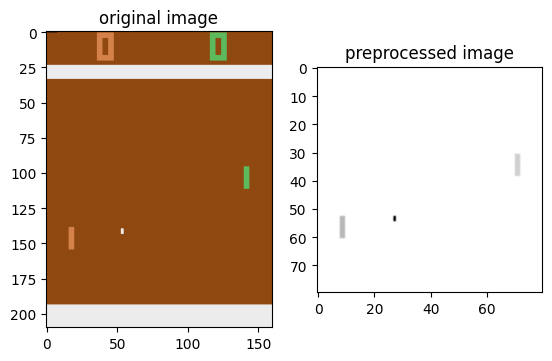

In [7]:

# show what a preprocessed image looks like
env.reset()

_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [8]:
# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)
        # 80x80x2 to 38x38x4
        # 2 channel from the stacked frame
        # (80 - 6 + 2)/2 = 38
        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False)

        # 38x38x4 to 9x9x32
        # (38 - 6 + 4)/4 = 9
        self.conv2 = nn.Conv2d(4, 16, kernel_size=6, stride=4)
        self.size=9*9*16
        
        # 2 fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)
        
        # Sigmoid to
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
    
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))
    

# use your own policy!
policy=Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress

In [9]:
RIGHT=4
LEFT=5

# function to animate a list of frames
def animate_frames(frames):
    plt.axis('off')

    # color option for plotting
    # use Greys for greyscale
    cmap = None if len(frames[0].shape)==3 else 'Greys'
    patch = plt.imshow(frames[0], cmap=cmap)  

    fanim = animation.FuncAnimation(plt.gcf(), \
        lambda x: patch.set_data(frames[x]), frames = len(frames), interval=30)
    
    video = fanim.to_html5_video()
    #display(display_animation(fanim, default_mode='once'))
    html = display.HTML(video)
    display.display(html)
    plt.close()             
    

# play a game and display the animation
# nrand = number of random steps before using the policy
def play(env, policy, time=2000, preprocess=None, nrand=5):
    env.reset()
    
    # start game
    env.step(1)
    
    # perform nrand random steps in the beginning
    for _ in range(nrand):
        frame1, reward1, is_done, _ = env.step(np.random.choice([RIGHT,LEFT]))
        frame2, reward2, is_done, _ = env.step(0)
    
    anim_frames = []
    
    for _ in range(time):
        frame_input = preprocess_batch([frame1, frame2])
        prob = policy(frame_input)
        
        # Right = 4, Left = 5
        action = RIGHT if random.random() < prob else LEFT
        frame1, _, done, _ = env.step(action)
        frame2, _, done, _ = env.step(0)
        
        if preprocess is None:
            anim_frames.append(frame1)
        else:
            anim_frames.append(preprocess(frame1))

        if done:
            break
            
    env.close()
    animate_frames(anim_frames)
    return

In [10]:
play(env, policy, time=200) 

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [11]:
# convert states to probability, passing through the policy
def states_to_prob(policy, states):
    states = torch.stack(states)
    policy_input = states.view(-1,*states.shape[-3:])
    return policy(policy_input).view(states.shape[:-3])

In [12]:
# clipped surrogate function
# similar as -policy_loss for REINFORCE, but for PPO
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount=0.995,
                      epsilon=0.1, beta=0.01):

    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10

    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = states_to_prob(policy, states)
    new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)
    
    # ratio for clipping
    ratio = new_probs/old_probs

    # clipped function
    clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    clipped_surrogate = torch.min(ratio*rewards, clip*rewards)

    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    
    # this returns an average of all the entries of the tensor
    # effective computing L_sur^clip / T
    # averaged over time-step and number of trajectories
    # this is desirable because we have normalized our rewards
    return torch.mean(clipped_surrogate + beta*entropy)

In [13]:
# collect trajectories for a parallelized parallelEnv object
def collect_trajectories(envs, policy, tmax=200, nrand=5):
    
    # number of parallel instances
    n=len(envs.ps)

    #initialize returning lists and start the game!
    state_list=[]
    reward_list=[]
    prob_list=[]
    action_list=[]

    envs.reset()
    
    # start all parallel agents
    envs.step([1]*n)
    
    # perform nrand random steps
    for _ in range(nrand):
        fr1, re1, _, _ = envs.step(np.random.choice([RIGHT, LEFT],n))
        fr2, re2, _, _ = envs.step([0]*n)
    
    for t in range(tmax):

        # prepare the input
        # preprocess_batch properly converts two frames into 
        # shape (n, 2, 80, 80), the proper input for the policy
        # this is required when building CNN with pytorch
        batch_input = preprocess_batch([fr1,fr2])
        
        # probs will only be used as the pi_old
        # no gradient propagation is needed
        # so we move it to the cpu
        probs = policy(batch_input).squeeze().cpu().detach().numpy()
        
        action = np.where(np.random.rand(n) < probs, RIGHT, LEFT)
        probs = np.where(action==RIGHT, probs, 1.0-probs)
        
        
        # advance the game (0=no action)
        # we take one action and skip game forward
        fr1, re1, is_done, _ = envs.step(action)
        fr2, re2, is_done, _ = envs.step([0]*n)

        reward = re1 + re2
        
        # store the result
        state_list.append(batch_input)
        reward_list.append(reward)
        prob_list.append(probs)
        action_list.append(action)
        
        # stop if any of the trajectories is done
        # we want all the lists to be retangular
        if is_done.any():
            break


    # return pi_theta, states, actions, rewards, probability
    return prob_list, state_list, \
        action_list, reward_list

# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [14]:
from parallelEnv import parallelEnv
import numpy as np
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 800

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 320
SGD_epoch = 4

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)


    # gradient ascent step
    for _ in range(SGD_epoch):
        
        # uncomment to utilize your own clipped function!
        L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

        
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%50 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

/tmp/ipykernel_23001/1251503627.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  actions = torch.tensor(actions, dtype=torch.int8, device=device)


Episode: 50, score: -15.000000
[-14. -14. -16. -16. -16. -15. -15. -14.]


Episode: 100, score: -14.500000
[-15. -12. -16. -14. -16. -16. -15. -12.]


Episode: 150, score: -12.250000
[-16. -15. -13. -13.  -8. -10. -10. -13.]


Episode: 200, score: -10.000000
[-15.  -5.  -7. -11. -11. -11. -11.  -9.]


Episode: 250, score: -7.375000
[-9. -7. -9. -9. -7. -4. -7. -7.]


Episode: 300, score: -4.125000
[ -1.  -5. -10.  -2.  -5.  -7.  -1.  -2.]


Episode: 350, score: -1.250000
[-5. -2. -1.  1. -1. -1.  0. -1.]


Episode: 400, score: 0.625000
[-1.  0.  0.  1.  2.  2.  0.  1.]


Episode: 450, score: 1.375000
[ 3.  1.  0.  3.  0. -1.  2.  3.]


Episode: 500, score: 2.500000
[ 4.  1.  3.  5. -2.  2.  4.  3.]


Episode: 550, score: 2.625000
[ 3. -3.  3.  0.  5.  5.  3.  5.]


Episode: 600, score: 3.375000
[ 5. -4.  5.  5.  5.  3.  3.  5.]


Episode: 650, score: 4.750000
[5. 5. 5. 5. 5. 5. 3. 5.]


Episode: 700, score: 3.875000
[ 5.  5.  3.  5.  5. -2.  5.  5.]


Episode: 750, score: 4.875000
[5. 5. 5. 5. 4. 5. 5. 5.]


Episode: 800, score: 5.000000
[5. 5. 5. 5. 5. 5. 5. 5.]


In [16]:
play(env, policy, time=2000) 

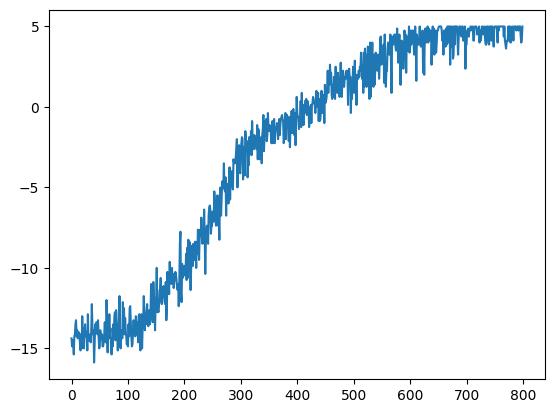

In [17]:
plt.plot(mean_rewards)

In [18]:
# save your policy!
torch.save(policy, 'PPO.policy')

# load policy if needed
# policy = torch.load('PPO.policy')

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO verion can win more often than not)!
#
# policy_solution = torch.load('PPO_solution.policy')
# pong_utils.play(env, policy_solution, time=2000) 